In [1]:
!pip install emoji
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs
!pip install accelerate -U
!pip install fastText

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 796.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fastText: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=a2f622ed6c15d7ce221b0a757d29d8be7cbbf8bb5e6d5f0999aa816e975fb58a
  Stored in directory:

In [ ]:
import os
os._exit(00)

In [1]:
import emoji
import re
import googleapiclient.discovery
import torch
import fasttext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from huggingface_hub import notebook_login

In [2]:
dev = ''
huggy_log =''
fast_text_model = fasttext.load_model('lid.176.ftz')
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = dev
youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

In [3]:
def clean_text(text):
    allchars = [str for str in text.decode('utf-8')]
    emoji_list = [c for c in allchars if c in emoji.EMOJI_DATA]
    clean_text = ' '.join([str for str in text.decode('utf-8').split() if not any(i in str for i in emoji_list)])
    clean_text = re.sub('http[s]?://\S+', '', clean_text)
    if fast_text_model.predict(clean_text, k=1)[0][0] == '__label__en':
      return clean_text
    return ''

In [4]:
def getcomments(video):
  request = youtube.commentThreads().list(
      part="snippet",
      videoId=video,
      maxResults=100
      )
  comments = []
  response = request.execute()
  for item in response['items']:
      comment = item['snippet']['topLevelComment']['snippet']
      text = clean_text(comment['textOriginal'].lower().strip().encode('utf8'))
      if text != '':
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            text,
            comment['videoId'],
        ])
  while (1 == 1):
    try:
     nextPageToken = response['nextPageToken']
    except KeyError:
     break
    nextPageToken = response['nextPageToken']
    nextRequest = youtube.commentThreads().list(part="snippet", videoId=video,
                                                maxResults=100, pageToken=nextPageToken)
    response = nextRequest.execute()
    for item in response['items']:
      comment = item['snippet']['topLevelComment']['snippet']
      text = clean_text(comment['textOriginal'].lower().strip().encode('utf8'))
      if text != '':
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            text,
            comment['videoId'],
        ])

  df = pd.DataFrame(comments, columns=['author', 'updated_at', 'like_count',
                                        'text','video_id'])
  return df

In [5]:
df = getcomments('0VH9WCFV6XQ')
df

,author,updated_at,like_count,text,video_id
0,@locksmith16,2023-12-17T17:56:26Z,0,the security breach movie should be the only f...,0VH9WCFV6XQ
1,@DoggoS5,2023-12-17T08:55:07Z,0,why do i always get the weirdos?!,0VH9WCFV6XQ
2,@shamchristin,2023-12-17T05:31:05Z,1,copy from original willy’s wonderland,0VH9WCFV6XQ
3,@falcon7270,2023-12-16T23:58:18Z,0,real fnaf experience on my channel,0VH9WCFV6XQ
4,@ammarrahman5354,2023-12-16T17:14:49Z,0,this movie was straight ass is was not even en...,0VH9WCFV6XQ
...,...,...,...,...,...
42149,@davidfaris6920,2023-06-27T14:59:57Z,0,first,0VH9WCFV6XQ
42150,@peanutbar015,2023-06-27T14:59:56Z,0,omg yasss,0VH9WCFV6XQ
42151,@ermset638,2023-06-27T14:59:56Z,0,yessss!!!!,0VH9WCFV6XQ
42152,@C-Lmemes,2023-06-27T14:59:52Z,1,omgggg,0VH9WCFV6XQ


In [6]:
torch.cuda.is_available()

True

In [7]:
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [8]:
train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(10000))])
test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(1000))])
print(train_dataset[0])
print(test_dataset[0])

{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}
{'text': "<br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, 

In [9]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [10]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions,
                                     references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [14]:
notebook_login(huggy_log)

In [15]:
repo_name = "finetuning-sentiment-roberta-base-model-10000-samples"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.282000
1000,0.156500


TrainOutput(global_step=1250, training_loss=0.2043305877685547, metrics={'train_runtime': 1866.8364, 'train_samples_per_second': 10.713, 'train_steps_per_second': 0.67, 'total_flos': 5168928869620992.0, 'train_loss': 0.2043305877685547, 'epoch': 2.0})

In [17]:
trainer.evaluate()

<ipython-input-13-93641f1fcfdf>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.19468653202056885,
 'eval_accuracy': 0.948,
 'eval_f1': 0.946611909650924,
 'eval_runtime': 34.49,
 'eval_samples_per_second': 28.994,
 'eval_steps_per_second': 1.827,
 'epoch': 2.0}

In [18]:
trainer.push_to_hub()

events.out.tfevents.1702839208.14ebde33629c.967.1:   0%|          | 0.00/457 [00:00<?, ?B/s]

'https://huggingface.co/pryshlyak/finetuning-sentiment-roberta-base-model-10000-samples/tree/main/'

In [19]:
sentiment_model = pipeline(model="pryshlyak/finetuning-sentiment-roberta-base-model-10000-samples")

sentiment_model(["I love it", "I hate it"])

config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.997821569442749},
 {'label': 'LABEL_0', 'score': 0.9775216579437256}]

In [20]:
def get_sentiment(df):
  list_comments = df["text"].astype(str).tolist()
  sentiments = []
  pos_score = 0
  neg_score = 0
  max_length = 256
  for i in range(0, len(list_comments)):
    sentiment = ''
    if len(list_comments[i]) > max_length:
      sentiment = sentiment_model(list_comments[i][:max_length])
    else:
      sentiment = sentiment_model(list_comments[i])
    if sentiment[0].get('label') == 'LABEL_0':
       sentiments.append('neg')
       if df['like_count'][i] > 0:
         neg_score += 1 * df['like_count'][i]
       else:
         neg_score += 1
    else:
       sentiments.append('pos')
       if df['like_count'][i] > 0:
         pos_score += 1 * df['like_count'][i]
       else:
         pos_score += 1
  return sentiments, pos_score, neg_score

In [21]:
sentiments, pos_score, neg_score = get_sentiment(df)
df['sentiments'] = sentiments
df

,author,updated_at,like_count,text,video_id,sentiments
0,@locksmith16,2023-12-17T17:56:26Z,0,the security breach movie should be the only f...,0VH9WCFV6XQ,pos
1,@DoggoS5,2023-12-17T08:55:07Z,0,why do i always get the weirdos?!,0VH9WCFV6XQ,pos
2,@shamchristin,2023-12-17T05:31:05Z,1,copy from original willy’s wonderland,0VH9WCFV6XQ,pos
3,@falcon7270,2023-12-16T23:58:18Z,0,real fnaf experience on my channel,0VH9WCFV6XQ,pos
4,@ammarrahman5354,2023-12-16T17:14:49Z,0,this movie was straight ass is was not even en...,0VH9WCFV6XQ,neg
...,...,...,...,...,...,...
42149,@davidfaris6920,2023-06-27T14:59:57Z,0,first,0VH9WCFV6XQ,pos
42150,@peanutbar015,2023-06-27T14:59:56Z,0,omg yasss,0VH9WCFV6XQ,neg
42151,@ermset638,2023-06-27T14:59:56Z,0,yessss!!!!,0VH9WCFV6XQ,pos
42152,@C-Lmemes,2023-06-27T14:59:52Z,1,omgggg,0VH9WCFV6XQ,neg


In [22]:
df.to_csv('fnf_movie_comments_roberta.csv', encoding='utf-8', index=False)

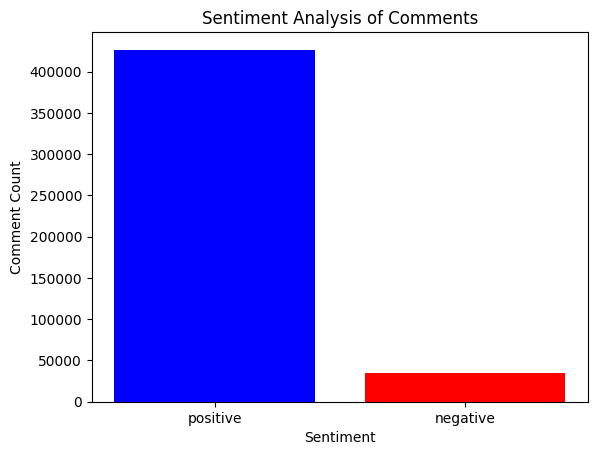

In [23]:
plt.bar(['positive', 'negative'], [pos_score, neg_score], color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')
plt.show()

In [25]:
print(pos_score)
print(neg_score)

426611
35147


In [26]:
df2 = getcomments('pBk4NYhWNMM')
df2

,author,updated_at,like_count,text,video_id
0,@largol33t12,2023-12-17T17:38:22Z,0,what's kinda funny is that mattel (the company...,pBk4NYhWNMM
1,@michaelkelly1757,2023-12-17T17:23:00Z,0,i want barbie 2,pBk4NYhWNMM
2,@shaikaalkuwari6131,2023-12-17T12:13:30Z,0,i love you barbie,pBk4NYhWNMM
3,@prismaticindia9046,2023-12-17T00:41:50Z,1,barbie should be beautiful and looking like a ...,pBk4NYhWNMM
4,@kenflint6127,2023-12-16T22:01:10Z,0,if taylor swift plays barbie...would have made...,pBk4NYhWNMM
...,...,...,...,...,...
22324,@henrysheffield3998,2023-05-25T16:01:24Z,0,real,pBk4NYhWNMM
22325,@Blaze-zt5qm,2023-05-25T16:01:24Z,0,fiesta,pBk4NYhWNMM
22326,@mollypercocet1718,2023-05-25T16:01:13Z,0,first,pBk4NYhWNMM
22327,@Carnaaqe,2023-05-25T16:01:00Z,0,w,pBk4NYhWNMM


In [27]:
sentiments, pos_score, neg_score = get_sentiment(df2)

In [28]:
df2['sentiments'] = sentiments
df2

,author,updated_at,like_count,text,video_id,sentiments
0,@largol33t12,2023-12-17T17:38:22Z,0,what's kinda funny is that mattel (the company...,pBk4NYhWNMM,pos
1,@michaelkelly1757,2023-12-17T17:23:00Z,0,i want barbie 2,pBk4NYhWNMM,pos
2,@shaikaalkuwari6131,2023-12-17T12:13:30Z,0,i love you barbie,pBk4NYhWNMM,pos
3,@prismaticindia9046,2023-12-17T00:41:50Z,1,barbie should be beautiful and looking like a ...,pBk4NYhWNMM,neg
4,@kenflint6127,2023-12-16T22:01:10Z,0,if taylor swift plays barbie...would have made...,pBk4NYhWNMM,pos
...,...,...,...,...,...,...
22324,@henrysheffield3998,2023-05-25T16:01:24Z,0,real,pBk4NYhWNMM,pos
22325,@Blaze-zt5qm,2023-05-25T16:01:24Z,0,fiesta,pBk4NYhWNMM,pos
22326,@mollypercocet1718,2023-05-25T16:01:13Z,0,first,pBk4NYhWNMM,pos
22327,@Carnaaqe,2023-05-25T16:01:00Z,0,w,pBk4NYhWNMM,pos


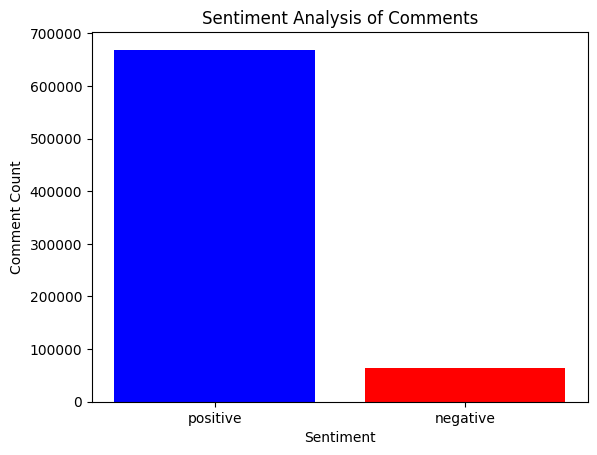

In [29]:
plt.bar(['positive', 'negative'], [pos_score, neg_score], color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')
plt.show()

In [30]:
df2.to_csv('barbie_movie_comments-roberta.csv', encoding='utf-8', index=False)

In [31]:
print(pos_score)
print(neg_score)

668671
63686


In [32]:
df3 = getcomments('uYPbbksJxIg')
df3

,author,updated_at,like_count,text,video_id
0,@EastAngliaUK,2023-12-16T09:23:45Z,0,the dts sound made the floorboards vibrate on ...,uYPbbksJxIg
1,@mistaboneka,2023-12-16T04:12:06Z,0,this is a movie about how america killed milli...,uYPbbksJxIg
2,@monishk6561,2023-12-15T23:38:23Z,0,this trailer actually follows the timeline of ...,uYPbbksJxIg
3,@CoDGameplay967,2023-12-15T21:59:34Z,0,“the world will remember this day” yes they wi...,uYPbbksJxIg
4,@apple213,2023-12-15T20:12:05Z,0,that final discussion between robert and alber...,uYPbbksJxIg
...,...,...,...,...,...
20361,@xxxbrwxxxaleksanderhs1572,2023-05-08T07:03:05Z,1,shit,uYPbbksJxIg
20362,@alluarbind7248,2023-05-08T07:02:54Z,1,love u from nepal first comment,uYPbbksJxIg
20363,@LandonH117,2023-05-08T07:02:38Z,5,first edit: i just went to go see guardians of...,uYPbbksJxIg
20364,@elonmusknigachocolate,2023-05-08T07:02:28Z,8,this trailer alone is screaming over 8.5 imdb ...,uYPbbksJxIg


In [33]:
sentiments, pos_score, neg_score = get_sentiment(df3)

In [34]:
df3['sentiments'] = sentiments
df3

,author,updated_at,like_count,text,video_id,sentiments
0,@EastAngliaUK,2023-12-16T09:23:45Z,0,the dts sound made the floorboards vibrate on ...,uYPbbksJxIg,pos
1,@mistaboneka,2023-12-16T04:12:06Z,0,this is a movie about how america killed milli...,uYPbbksJxIg,pos
2,@monishk6561,2023-12-15T23:38:23Z,0,this trailer actually follows the timeline of ...,uYPbbksJxIg,pos
3,@CoDGameplay967,2023-12-15T21:59:34Z,0,“the world will remember this day” yes they wi...,uYPbbksJxIg,pos
4,@apple213,2023-12-15T20:12:05Z,0,that final discussion between robert and alber...,uYPbbksJxIg,pos
...,...,...,...,...,...,...
20361,@xxxbrwxxxaleksanderhs1572,2023-05-08T07:03:05Z,1,shit,uYPbbksJxIg,pos
20362,@alluarbind7248,2023-05-08T07:02:54Z,1,love u from nepal first comment,uYPbbksJxIg,pos
20363,@LandonH117,2023-05-08T07:02:38Z,5,first edit: i just went to go see guardians of...,uYPbbksJxIg,pos
20364,@elonmusknigachocolate,2023-05-08T07:02:28Z,8,this trailer alone is screaming over 8.5 imdb ...,uYPbbksJxIg,pos


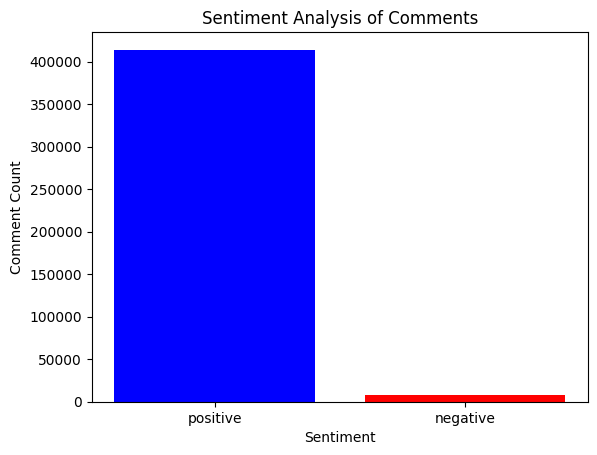

In [35]:
plt.bar(['positive', 'negative'], [pos_score, neg_score], color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')
plt.show()

In [36]:
df3.to_csv('oppenheimer_movie_comments_roberta.csv', encoding='utf-8', index=False)

In [37]:
print(pos_score)
print(neg_score)

413982
8257


In [38]:
count = 0
for i in range(0, len(df['text'])):
  if df['sentiments'][i] == 'neg':
    print(df['text'][i])
    count += 1
print(count)

Показано результат, скорочений до останніх рядків (5000).
you just know it's going to be absolute dogshit
it so hard to tell what this movie is rated
sad that it didn’t start with “hello? hello hello?”
bro if they some how make a roller coaster it would be awsome
who here thinks that the officer is actually vanessa?
it is tough to tell 100% from the trailer, but it looks like freddy and the gang are going to be cgi. i understand its cheaper, but that is a huge missed opportunity and will take away from the horror. practical effects would have been leaps and bounds better for this in particular.
holy fuck
so its not canon.
why did they show spring trip so early he’s supposed to be in fnaf three
so if cory is in this, i can only imagine other big youtubers like markiplier will probably end up in this movie too
why the animatronics look like sfm fan animations
i will work and you will sleep - i smell bad dialogue
it looks bad icl
it’s almost ten years since this horror indie game came out

In [39]:
count = 0
for i in range(0, len(df2['text'])):
  if df2['sentiments'][i] == 'neg':
    print(df2['text'][i])
    count += 1
print(count)

Показано результат, скорочений до останніх рядків (5000).
dont watch this shite. misandrist move, completely anti-man.
most woke movie of 2023. hard pass.
this looks terrible.... and unfunny... marketing trash...
only two things that made me laugh in this trailer. ken getting arrested.then bad guy boss man, will ferrell not a lego lmao
<——- confused. what did i just watch?
i'd rather watch the view, and i hate that show
we really have become "idiocracy." ... and since when does ken have white hair and crow's feet?
oppenheimer just gonna lick barbie's
this is the gayest , lamest, most worthless waste of money and time !! kudos to the weirdos who go see it !
its trash its horrível
i love that no matter how much money this movie makes the bad pr created by this movie will lead the barbie brand to ruin. careful who you trust to be your bussiness partners i guess.
chase this fukin oppenheimer awayyyyyy!!
boooo. no one cares for the woke garbage, that's why yall pulled a bait and switch.
so 

In [40]:
count = 0
for i in range(0, len(df3['text'])):
  if df3['sentiments'][i] == 'neg':
    print(df3['text'][i])
    count += 1
print(count)

fading to black every three seconds is annoying af.
i could not hear a word in the actual movie. classic nolan
i did not like this. it was like watching fear and lothan in las vegas
i think a mascot change is in order. the nebraska turdburglars. knock kneed athletes coming to a theater near you! watch our inept athletes not recover a single self imposed fumble all year....because we just.......can't. no hand eye coordination. no marks of a good athlete. love how they buy there way into the the top 25 recruiting mags every year but yet.........not at top 25 class. uncoordinated jerkoffs!
nebraska still sucks. the king of college football choke. on and off field.
did a russian produce this movie?
ughh.......how did this turd of a movie make it to 4 stars? i says 2 stars max. and that was because i tried to stay awake for the the first 2 hours. excellent topic....turd of a product.
so confusing. no ides what’s happening
it’s so hard to believe that they got thomas shelby to play this
seem